# PyBet : Beat the bookmakers

#### The objective of this project is to try to beat bookmakers' algorithms on estimating the probability of a team winning a tennis match. In a first step we will study and apply methods to clean the dataset. Once the dataset is clean, a second step is to extract from the match history the characteristics that seem to be relevant to estimate the performance of a player (ranking, type of tournament, etc.). Finally, from these features, we will estimate the probability that a player A beats a player B.

#### The dataset comes from the website (kaggle https://www.kaggle.com/edouardthomas/atp-matches-dataset) . This is a csv file csv atp_data.csv (from website tennis.co.uk data) listing all tennis matches between the years 2000 and 2018. The dataset contains 23 variables and 44 708 matches (rows).

## Contents:

1. Data Exploration
2. Data Visualisation
3. Features engineering
4. ML
5. ML test function
6. Interpretability

# 0. Loading of librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Classification models that will be used
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from joblib import dump, load

# Models evaluation
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

# 1. Data Exploration & Cleaning

In [2]:
#1er look of the dataset
url = "https://raw.githubusercontent.com/fadilnjimoun/PyBet/main/Data/atp_data.csv"
df = pd.read_csv(url)
display(df.iloc[:,:10].head(2))
display(df.iloc[:,10:].head(2))

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.


,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,Ljubicic I.,63,77,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
1,Tarango J.,6,59,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5


In [3]:
# Some information on the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44708 entries, 0 to 44707
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         44708 non-null  int64  
 1   Location    44708 non-null  object 
 2   Tournament  44708 non-null  object 
 3   Date        44708 non-null  object 
 4   Series      44708 non-null  object 
 5   Court       44708 non-null  object 
 6   Surface     44708 non-null  object 
 7   Round       44708 non-null  object 
 8   Best of     44708 non-null  int64  
 9   Winner      44708 non-null  object 
 10  Loser       44708 non-null  object 
 11  WRank       44708 non-null  int64  
 12  LRank       44708 non-null  int64  
 13  Wsets       44521 non-null  float64
 14  Lsets       44521 non-null  float64
 15  Comment     44708 non-null  object 
 16  PSW         32743 non-null  float64
 17  PSL         32743 non-null  float64
 18  B365W       39037 non-null  float64
 19  B365L       39057 non-nul

##### We have 23 variables, 13 of whom continuous (quantitatives) et 10 categoricals (qualitatives)

In [4]:
# The dataset does not have a priori description, let us try to understand the different variables and describe them

df.nunique()

ATP              69
Location        115
Tournament      207
Date           4104
Series            8
Court             2
Surface           4
Round             8
Best of           2
Winner          899
Loser          1400
WRank           587
LRank           920
Wsets             4
Lsets             3
Comment           4
PSW            1177
PSL            1580
B365W           133
B365L           137
elo_winner    44297
elo_loser     43522
proba_elo     44555
dtype: int64

In [5]:
# Variable 'Comment'
df.Comment.unique()
# This variable lets you know if the match has come to an end

array(['Completed', 'Retired', 'Walkover', 'Disqualified'], dtype=object)

In [6]:
# Variable 'Series'
df.Series.unique()
# Tournament type

array(['International', 'Grand Slam', 'International Gold', 'Masters',
       'Masters Cup', 'ATP250', 'ATP500', 'Masters 1000'], dtype=object)

In [7]:
# Variable 'Round'
df.Round.unique()
# Competition stage

array(['1st Round', 'Semifinals', 'Quarterfinals', '2nd Round',
       'The Final', '3rd Round', '4th Round', 'Round Robin'], dtype=object)

In [8]:
# Variable 'Winner'
df.Winner.sort_values().unique()

array([' Hajek J.', 'Abel M.', 'Acasuso J.', 'Agassi A.', 'Agenor R.',
       'Aguilar J.', 'Ahouda A.', 'Al Ghareeb M.', 'Alami K.', 'Albot R.',
       'Aldi F.', 'Allegro Y.', 'Almagro N.', 'Alonso J.', 'Altmaier D.',
       'Alund M.', 'Alvarez E.', 'Alves T.', 'Amritraj P.', 'Ancic I.',
       'Ancic M.', 'Andersen J.F.', 'Anderson K.', 'Andreev I.',
       'Andreozzi G.', 'Andujar P.', 'Arazi H.', 'Arguello F.',
       'Armando H.', 'Arnaboldi A.', 'Arthurs W.', 'Ascione A.',
       'Ascione T.', 'Auckland J.', 'Baccanello P.', 'Bachelot J.F',
       'Bachinger M.', 'Baghdatis M.', 'Bagnis F.', 'Bai Y.', 'Baker B.',
       'Baker J.', 'Balazs A.', 'Balcells J.', 'Ball C.', 'Balleret B.',
       'Barton M.', 'Basic M.', 'Basilashvili N.', 'Bastl G.',
       'Bautista Agut R.', 'Bautista R.', 'Beck A.', 'Beck K.',
       'Becker B.', 'Bedene A.', 'Behrend T.', 'Bellucci T.',
       'Bemelmans R.', 'Benneteau J.', 'Berankis R.', 'Berasategui A.',
       'Berdych T.', 'Berdych T. ', '

##### There are duplicates for the following reasons:

- Spaces before and after some names. Ex: "Federer". Solution: Remove spaces
- Forgotten abbreviation points. Ex: 'Marin J.A', 'Marin J.A.'. Solution: Add the points
- Dashes forgotten on compound names. Ex: 'Carreno-Busta P.'. Solution: Add the dashes


Let us apply to this column of functions which correct these errors.

In [9]:
def remove_space(nom):
    if type(nom) == str:
        resultat = nom
        if nom[0] == ' ':
            resultat = nom[1:]
        if resultat[-1] == ' ':
            resultat = resultat[:-1]
        return resultat
    return nom

def add_mark(nom):
    if type(nom) == str:
        if nom[-1] != '.' and nom != np.nan:
            return nom + '.'
        return nom
    return nom

def add_dash(nom):
    if type(nom) == str:
        compteur = 0
        indice = 0
        for i,j in enumerate(reversed(nom)):
            if j == ' ':
                compteur += 1
                indice = i
        if compteur == 2:
            return nom[:indice-1] + '-' + nom[indice:]
    return nom

In [10]:
df[['Winner', 'Loser']] = df.apply({'Winner' : remove_space, 'Loser' : remove_space})
df[['Winner', 'Loser']] = df.apply({'Winner' : add_dash, 'Loser' : add_dash})
df[['Winner', 'Loser']] = df.apply({'Winner' : add_mark, 'Loser' : add_mark})

In [11]:
# Variable 'PSW'
display(df.PSW.sort_values().unique())
df.iloc[:,10:].loc[df.PSW >1]

# 'PS_', 'B365_' bookmakers odds

array([ 1.   ,  1.007,  1.008, ..., 41.   , 46.   ,    nan])

,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
8678,Kiefer N.,246,58,2.0,0.0,Completed,2.210,1.719,2.200,1.615,1486.195239,1618.182210,0.318694
8679,Schuettler R.,43,6,2.0,0.0,Completed,3.250,1.385,2.875,1.364,1615.057648,1820.759485,0.234313
8680,Carraz G.,39,67,2.0,1.0,Completed,1.746,2.180,1.571,2.250,1654.468551,1588.330984,0.594046
8682,Pless K.,97,440,2.0,0.0,Completed,1.562,2.580,1.571,2.250,1533.308961,1473.299803,0.585511
8683,Portas A.,111,85,2.0,0.0,Completed,1.641,2.360,1.570,2.250,1401.283125,1418.621881,0.475068
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44703,Pouille L.,23,15,2.0,0.0,Completed,1.650,2.430,1.660,2.200,1835.901543,1842.459807,0.490563
44704,Donaldson J.,8,59,2.0,1.0,Completed,1.340,3.630,1.300,3.500,1843.576914,1647.967561,0.755103
44705,Zeballos H.,73,69,2.0,1.0,Completed,1.850,2.090,1.900,1.900,1588.293069,1619.758421,0.454841
44706,Anderson K.,9,8,2.0,0.0,Completed,1.520,2.750,1.500,2.620,1966.532849,1851.413609,0.659862


In [12]:
# Variable 'elo_', 'proba_elo' : elo ranking

In [13]:
# Description des variables
""" 
0 ATP : ATP number of the tournament
1 Location : City's match
2 Tournament : Tournament name 
3 Date : Match day 
4 Series : Tournament type
5 Court : Indoor / Outdoor 
6 Surface : Pitch type
7 Round : Competition stage
8 Best of : Best score
9 Winner : Match winner 
10 Loser : Match loser 
11 WRank : Winner ATP rankig   
12 LRank : Loser ATP rankig
13 Wsets : Winner score
14 Lsets : Loser score
15 Comment : Finshed or unfinished match ? """

" \n0 ATP : ATP number of the tournament\n1 Location : City's match\n2 Tournament : Tournament name \n3 Date : Match day \n4 Series : Tournament type\n5 Court : Indoor / Outdoor \n6 Surface : Pitch type\n7 Round : Competition stage\n8 Best of : Best score\n9 Winner : Match winner \n10 Loser : Match loser \n11 WRank : Winner ATP rankig   \n12 LRank : Loser ATP rankig\n13 Wsets : Winner score\n14 Lsets : Loser score\n15 Comment : Finshed or unfinished match ? "

In [14]:
# Duplicates presence ?
df.duplicated().sum()

0

### Missing values

In [15]:
# Missing values presence
df.isnull().sum()

ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Winner            0
Loser             0
WRank             0
LRank             0
Wsets           187
Lsets           187
Comment           0
PSW           11965
PSL           11965
B365W          5671
B365L          5651
elo_winner        0
elo_loser         0
proba_elo         0
dtype: int64

In [16]:
df.isnull().sum()

ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Winner            0
Loser             0
WRank             0
LRank             0
Wsets           187
Lsets           187
Comment           0
PSW           11965
PSL           11965
B365W          5671
B365L          5651
elo_winner        0
elo_loser         0
proba_elo         0
dtype: int64

##### The uncompleted matches or whose socre are not known are a limited interest in the card of this analysis.
#### Thus, we are going to focus on the matches including "How = 'Completed'" and whose scores are known.

In [17]:
df1 = df.loc[(df.Comment == 'Completed') & (df.Wsets.notna()) & (df.Lsets.notna())]

display(df1.iloc[:,:10].head(2))
display(df1.iloc[:,10:].head(2))

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.


,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,Ljubicic I.,63,77,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
1,Tarango J.,6,59,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5


In [18]:
# Sometimes we miss values for B365 and not for PS, and vice versa.
# We choose first to replace missing values of one bookmaker with the values of the other bookmaker.

In [19]:
df1.loc[(df1.B365W.isna()==True) & (df1.PSW > 0), 'B365W'] = df1.loc[(df1.B365W.isna()==True) & (df1.PSW > 0), 'PSW']
df1.loc[(df1.B365L.isna()==True) & (df1.PSW > 0), 'B365L'] = df1.loc[(df1.B365L.isna()==True) & (df1.PSW > 0), 'PSL']
df1.loc[(df1.PSL.isna()==True) & (df1.B365W > 0), 'PSL'] = df1.loc[(df1.PSL.isna()==True) & (df1.B365W > 0), 'B365L']
df1.loc[(df1.PSW.isna()==True) & (df1.B365W > 0), 'PSW'] = df1.loc[(df1.PSW.isna()==True) & (df1.B365W > 0), 'B365W']

In [20]:
df1.isna().sum()

ATP              0
Location         0
Tournament       0
Date             0
Series           0
Court            0
Surface          0
Round            0
Best of          0
Winner           0
Loser            0
WRank            0
LRank            0
Wsets            0
Lsets            0
Comment          0
PSW           5087
PSL           5087
B365W         5087
B365L         5087
elo_winner       0
elo_loser        0
proba_elo        0
dtype: int64

###### Lets replace remaining missing odds values by 1

In [21]:
bookmakers = ['PSW', 'PSL', 'B365W', 'B365L']
for i in bookmakers:
    df1[i].fillna(1, axis=0, inplace=True)
df1.isna().sum().sum()

C:\Users\fadil\AppData\Local\Temp\ipykernel_93924\1218725977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i].fillna(1, axis=0, inplace=True)


0

In [22]:
# The variables Wsets and Lsets are of type 'float'. They should be of type 'int'.
# The Date variable also has the wrong type
df1 = df1.astype({'Wsets' : 'int', 'Lsets' : 'int', 'Date' : 'datetime64'})

##### Quick description of varibles

In [23]:
display(df1.describe(include=[np.number])) # Description des variables numériques

display(df1.describe(exclude=[np.number])) # Description des variables catégroielles

,ATP,Best of,WRank,LRank,Wsets,Lsets,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
count,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000
mean,32.773004,3.369833,58.853559,94.464523,2.184893,0.411540,1.786088,3.727550,1.712667,3.269369,1684.866154,1607.389932,0.588200
std,18.174624,0.776469,74.376858,125.461112,0.388694,0.559003,1.231010,5.156139,1.052423,3.414754,179.382693,137.488328,0.197758
min,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1318.945207,1327.551888,0.008899
25%,19.000000,3.000000,16.000000,35.000000,2.000000,0.000000,1.167000,1.560000,1.140000,1.500000,1549.287096,1500.768657,0.451174
50%,32.000000,3.000000,41.000000,66.000000,2.000000,0.000000,1.444000,2.380000,1.400000,2.250000,1653.976062,1578.913083,0.591985
75%,49.000000,3.000000,77.000000,106.000000,2.000000,1.000000,1.962000,3.850000,1.900000,3.750000,1781.647774,1683.075379,0.739046
max,69.000000,5.000000,1890.000000,2000.000000,3.000000,2.000000,46.000000,121.000000,29.000000,101.000000,2392.408923,2383.577360,0.995601


C:\Users\fadil\AppData\Local\Temp\ipykernel_93924\314419191.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df1.describe(exclude=[np.number])) # Description des variables catégroielles


,Location,Tournament,Date,Series,Court,Surface,Round,Winner,Loser,Comment
count,43014,43014,43014,43014,43014,43014,43014,43014,43014,43014
unique,115,207,4100,8,2,4,8,853,1329,1
top,Paris,Australian Open,2000-01-17 00:00:00,International,Outdoor,Hard,1st Round,Federer R.,Lopez F.,Completed
freq,2660,2067,124,10400,35138,22892,19920,945,360,43014
first,NaN,NaN,2000-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2018-03-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Data Visualisation

### 2.1. Players with the most victories

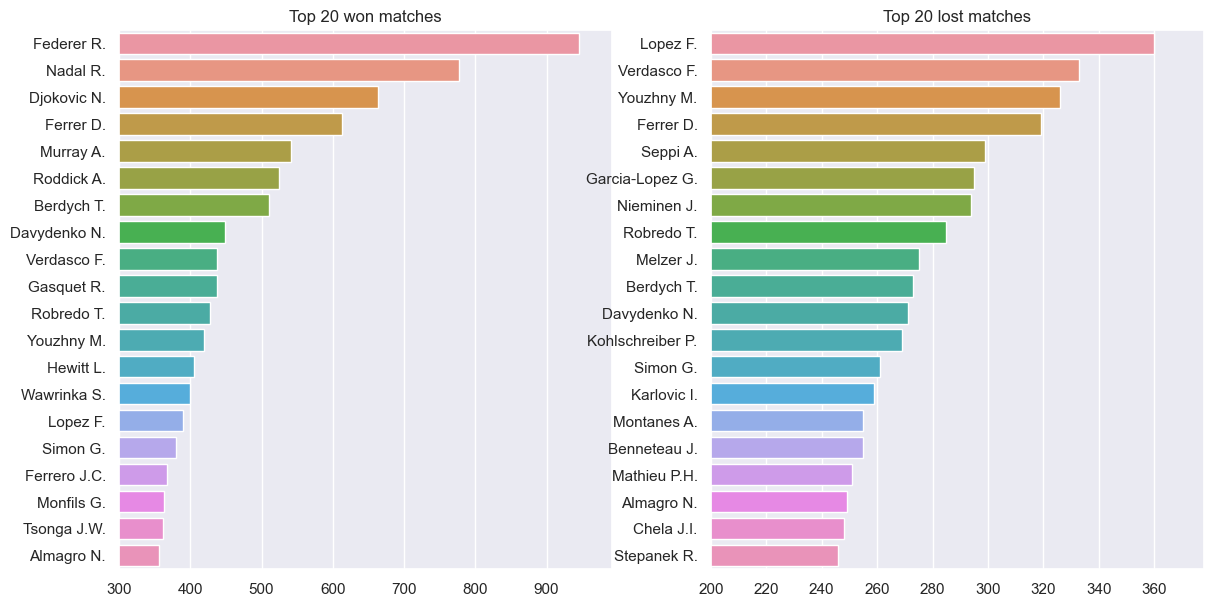

In [24]:
# Players who have won the most matches
sns.set()

plt.figure(figsize=(14,7))

plt.subplot(121)
data = df1.Winner.value_counts()[:20]
x, y = data.values, data.index
sns.barplot(x=x, y=y, data=pd.DataFrame(data), order = y, orient='h')
plt.xlim((300,None)); plt.title('Top 20 won matches')

# Players who have lost the most matches
plt.subplot(122)
data = df1.Loser.value_counts()[:20]
x, y = data.values, data.index
sns.barplot(x=x, y=y, data=pd.DataFrame(data), order = y, orient='h')
plt.xlim((200,None)); plt.title('Top 20 lost matches');

##### Federer, Nadal and Djokovic form the top 3

##### Players not having the same number of matches played, let's introduce the variable "w_per_match"

### 2.2. Overall performances

In [25]:
win_loss = pd.DataFrame(df1.Winner.value_counts()).join(pd.DataFrame(df1.Loser.value_counts()))
win_loss.head()

,Winner,Loser
Federer R.,945,189
Nadal R.,777,163
Djokovic N.,664,135
Ferrer D.,613,319
Murray A.,541,159


In [26]:
# w_per_match = Nb of won matches / Nb of lost matches
win_loss['w_per_match'] = round(win_loss.Winner / (win_loss.Winner + win_loss.Loser),3)
win_loss['matches'] = win_loss.Winner + win_loss.Loser
win_loss.sort_values('w_per_match', ascending=False, inplace=True)
win_loss.head(10)

,Winner,Loser,w_per_match,matches
Federer R.,945,189,0.833,1134
Djokovic N.,664,135,0.831,799
Nadal R.,777,163,0.827,940
Nargiso D.,8,2,0.800,10
Murray A.,541,159,0.773,700
Agassi A.,213,65,0.766,278
Roddick A.,525,168,0.758,693
Sampras P.,65,24,0.730,89
Del Potro-J.M.,349,138,0.717,487
Hewitt L.,405,176,0.697,581


#### Is there a correlation between performance and the number of matches played ?
##### Let's do a statistical test : test de pearson

###### H0 : There is no correlation between performance and the number of matches played

In [27]:
from scipy.stats import pearsonr

test = pearsonr(win_loss.w_per_match, win_loss.matches)
pd.DataFrame(pearsonr(win_loss.w_per_match, win_loss.matches), index=['pearson_coeff','p-value'], columns=['resultat_test'])

,resultat_test
pearson_coeff,5.527242e-01
p-value,2.106937e-69


##### We can reject the null hypothesis and conclude that the 2 variables are very dependent because the Pearson coefficient is close to 1 and the p-value is <<< 5%.

##### Let's check this graphically

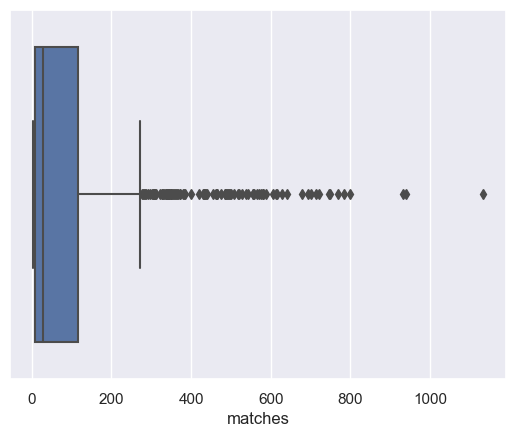

In [28]:
sns.boxplot(x='matches', data=win_loss);

##### The number of matches played varies greatly. We can split the data based on the number of games played

In [29]:
labels = ['Very irregular player', 'Irregular player', 'Regular player', 'Very regular player']
win_loss['cat_match'] = pd.cut(x=win_loss.matches, bins=4, labels=labels)
win_loss.head()

,Winner,Loser,w_per_match,matches,cat_match
Federer R.,945,189,0.833,1134,Very regular player
Djokovic N.,664,135,0.831,799,Regular player
Nadal R.,777,163,0.827,940,Very regular player
Nargiso D.,8,2,0.800,10,Very irregular player
Murray A.,541,159,0.773,700,Regular player


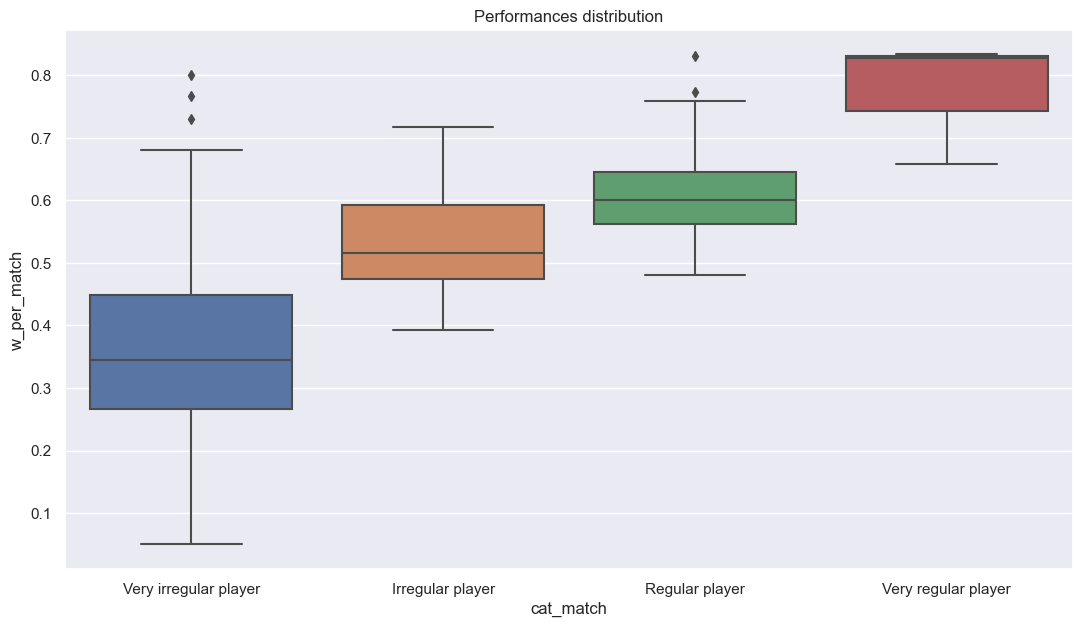

In [30]:
plt.figure(figsize=(13,7))
sns.boxplot(x='cat_match', y='w_per_match', data=win_loss)
plt.title('Performances distribution');

##### The more matches we play, the better the performance. The more you play, the more chances you have of winning. The graph the conclusions of the pearson test.

C:\Users\fadil\AppData\Local\Temp\ipykernel_93924\934223818.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.title('Top 20 performance'); plt.grid(b=True);
C:\Users\fadil\AppData\Local\Temp\ipykernel_93924\934223818.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.title('Flop 20 performance'); plt.grid(b=True);


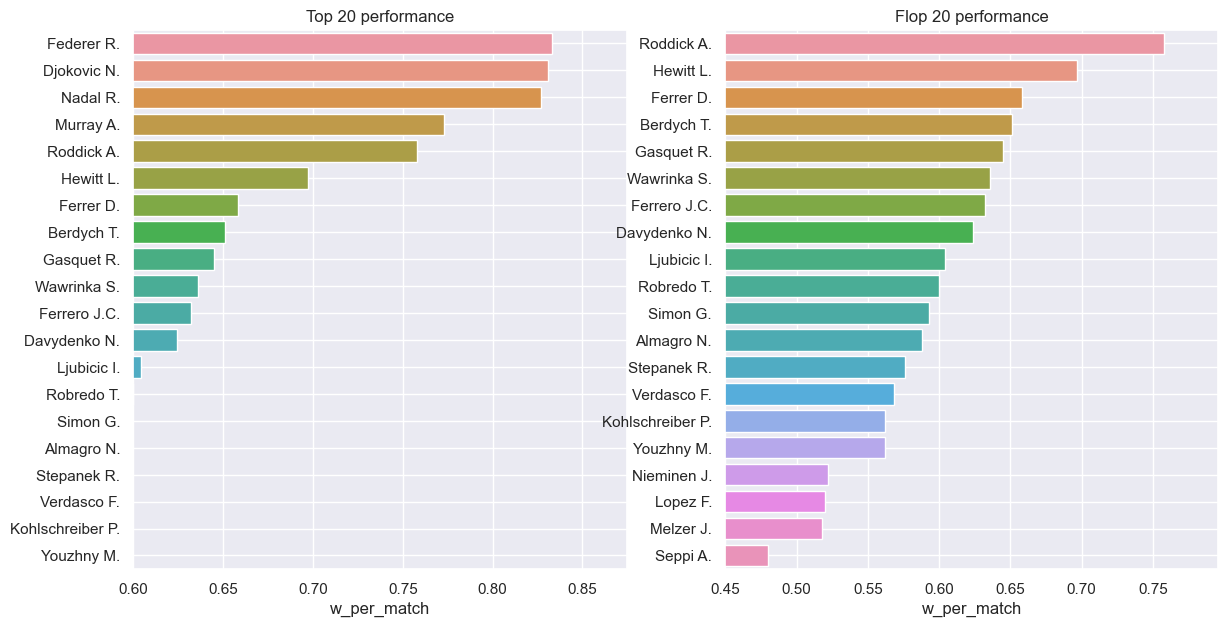

In [31]:
# Performance of those who have played more than 157 matches (the last quantiles)

# Top 20 performces

plt.figure(figsize=(14,7))

plt.subplot(121)
data = win_loss.loc[win_loss.cat_match >= 'Regular player'].head(20)
x, y = data.w_per_match, data.index
sns.barplot(x=x, y=y, data=data, order = y, orient='h'); plt.xlim((0.6, None));
plt.title('Top 20 performance'); plt.grid(b=True);

# Flop 20
plt.subplot(122)
data = win_loss.loc[win_loss.cat_match >= 'Regular player'].tail(20)
x, y = data.w_per_match, data.index
sns.barplot(x=x, y=y, data=data, order=y, orient='h'); plt.xlim((0.45, None)); 
plt.title('Flop 20 performance'); plt.grid(b=True);

##### Players who have played more than 157 matches win more than 60% of their matches.

#### Is there a correlation between performance and the type of tournament played? Let's proceed with a statistical test: ANOVA test

### 2.3. Performances by series type

In [32]:
#buffer dataFrame
winner_tampon = pd.DataFrame(df1[['Winner', 'Series']].value_counts()).reset_index()
winner_tampon.rename({'Winner' : 'Player', 0: 'Winner'}, inplace=True, axis=1)
#winner_tampon.set_index('Player', inplace=True)

loser_tampon = pd.DataFrame(df1[['Loser', 'Series']].value_counts()).reset_index()
loser_tampon.rename({'Loser' : 'Player', 0: 'Loser'}, inplace=True, axis=1)
#loser_tampon.set_index('Player', inplace=True)

win_loss_ser = winner_tampon.merge(right=loser_tampon, on=['Player','Series'], how='right')

win_loss_ser

,Player,Series,Winner,Loser
0,Garcia-Lopez G.,ATP250,106.0,92
1,Istomin D.,ATP250,85.0,90
2,Martin A.,International,71.0,85
3,Spadea V.,International,92.0,84
4,Rochus C.,International,53.0,81
...,...,...,...,...
3827,Lokoli L.,ATP250,NaN,1
3828,Lojda D.,Grand Slam,NaN,1
3829,Lisnard J.,Masters,1.0,1
3830,Lipsky S.,International,NaN,1


In [33]:
win_loss_ser = win_loss_ser.fillna(0)

In [34]:
win_loss_ser['matches'] = win_loss_ser.Winner + win_loss_ser.Loser
win_loss_ser['w_per_match'] = round(win_loss_ser.Winner / win_loss_ser.matches,3)

win_loss_ser.sort_values(by = ['w_per_match', 'Series'], ascending=False, inplace=True)
win_loss_ser.set_index('Player', inplace=True)

##### H0 : Performance and tournament type are independent

In [35]:
import statsmodels.api

result = statsmodels.formula.api.ols('w_per_match ~ Series', data=win_loss_ser).fit()
table = statsmodels.api.stats.anova_lm(result)

table

,df,sum_sq,mean_sq,F,PR(>F)
Series,7.0,1.161460,0.165923,3.095146,0.002954
Residual,3824.0,204.994887,0.053607,NaN,NaN


##### The p-value (PR(>F)) is < 5%, so we reject the null hypothesis

In [36]:
labels = ['Very irregular player', 'Irregular player', 'Regular player', 'Very regular player']
win_loss_ser['cat_match'] = pd.cut(x=win_loss_ser.matches, bins=4, labels=labels)

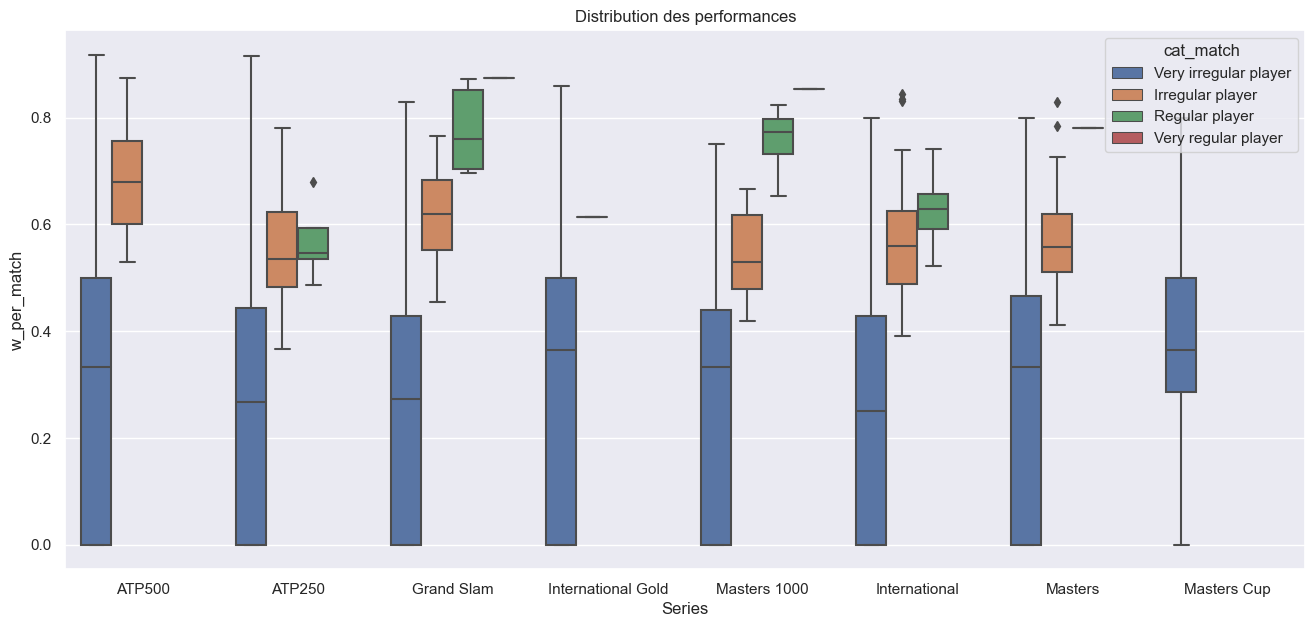

In [37]:
# Graphical verification 

plt.figure(figsize=(16,7))
sns.boxplot(data=win_loss_ser, x='Series', y='w_per_match', hue='cat_match')
plt.title('Distribution des performances');

##### Best players performance

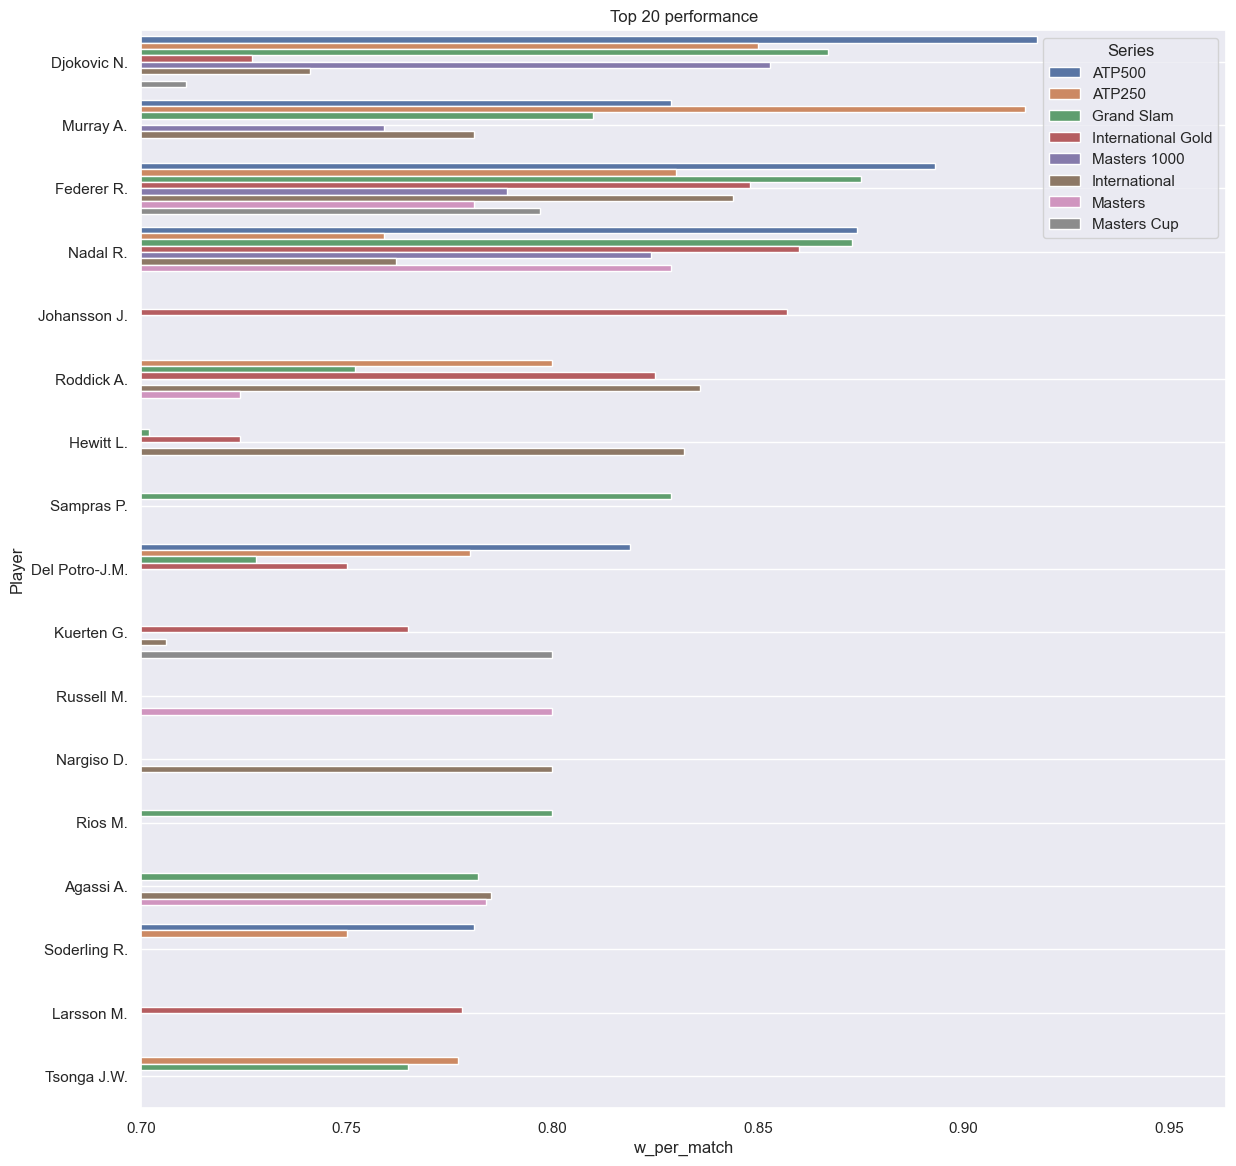

In [38]:
# Top 20 performces

plt.figure(figsize=(14,14))

y_uniq = win_loss_ser.head(40).index.unique()

data = win_loss_ser.loc[win_loss_ser.index.isin(y_uniq)]
x, y = data.w_per_match, data.index
sns.barplot(x=x, y=y, data=data, hue='Series', orient='h'); plt.xlim((0.7, None));
plt.title('Top 20 performance'); plt.grid();

#### Is there a correlation between performance and the type of court?
##### Let's proceed with a statistical test: ANOVA test

### 2.3. Performances en fonction du type de court

In [39]:
# buffer dataFrame
winner_tampon = pd.DataFrame(df1[['Winner', 'Court']].value_counts()).reset_index()
winner_tampon.rename({'Winner' : 'Player', 0: 'Winner'}, inplace=True, axis=1)

loser_tampon = pd.DataFrame(df1[['Loser', 'Court']].value_counts()).reset_index()
loser_tampon.rename({'Loser' : 'Player', 0: 'Loser'}, inplace=True, axis=1)

win_loss_cou = winner_tampon.merge(right=loser_tampon, on=['Player','Court'], how='right')

win_loss_cou

,Player,Court,Winner,Loser
0,Lopez F.,Outdoor,318.0,282
1,Verdasco F.,Outdoor,378.0,275
2,Youzhny M.,Outdoor,301.0,260
3,Ferrer D.,Outdoor,530.0,257
4,Garcia-Lopez G.,Outdoor,206.0,241
...,...,...,...,...
1988,Massa E.,Indoor,NaN,1
1989,Masur D.,Indoor,NaN,1
1990,Masur D.,Outdoor,NaN,1
1991,Mathieu P.,Indoor,NaN,1


In [40]:
win_loss_cou = win_loss_cou.fillna(0)

In [41]:
win_loss_cou['matches'] = win_loss_cou.Winner + win_loss_cou.Loser
win_loss_cou['w_per_match'] = round(win_loss_cou.Winner / win_loss_cou.matches,3)

win_loss_cou.sort_values(by = ['w_per_match', 'Player', 'Court'], ascending=False, inplace=True)
win_loss_cou

,Player,Court,Winner,Loser,matches,w_per_match
120,Djokovic N.,Outdoor,571.0,101,672.0,0.850
77,Nadal R.,Outdoor,712.0,130,842.0,0.846
56,Federer R.,Outdoor,744.0,145,889.0,0.837
301,Federer R.,Indoor,201.0,44,245.0,0.820
1652,Jarry N.,Indoor,4.0,1,5.0,0.800
...,...,...,...,...,...,...
1718,Agostinelli B.,Outdoor,0.0,1,1.0,0.000
1236,Ager J.,Outdoor,0.0,2,2.0,0.000
1717,Agaev E.,Outdoor,0.0,1,1.0,0.000
1716,Adaktusson J.,Outdoor,0.0,1,1.0,0.000


##### H0 : Performance and tournament type are independent

In [42]:
import statsmodels.api

result = statsmodels.formula.api.ols('w_per_match ~ Court', data=win_loss_cou).fit()
table = statsmodels.api.stats.anova_lm(result)

table

,df,sum_sq,mean_sq,F,PR(>F)
Court,1.0,0.633924,0.633924,12.768182,0.000361
Residual,1991.0,98.850551,0.049649,NaN,NaN


##### The p-value (PR(>F)) is < 5%, so we reject the null hypothesis

In [43]:
win_loss_cou['cat_match'] = pd.cut(x=win_loss_cou.matches, bins=4, labels=labels)

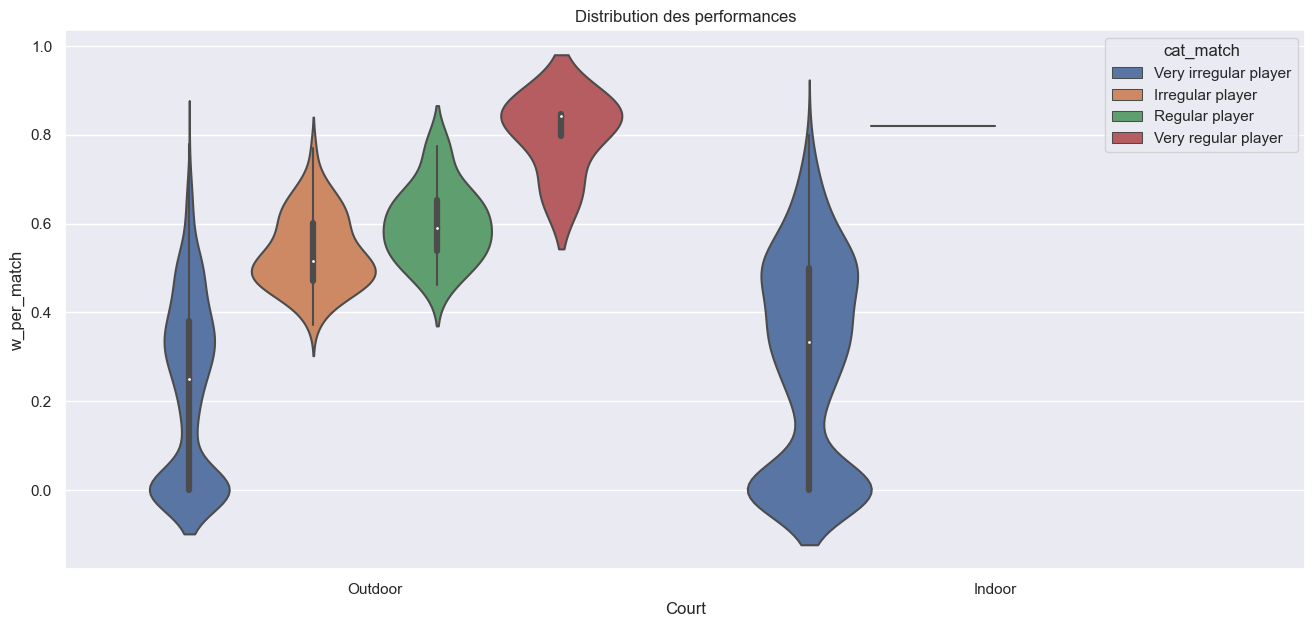

In [44]:
# Graphical verification

plt.figure(figsize=(16,7))
sns.violinplot(data=win_loss_cou, x='Court', y='w_per_match', hue='cat_match')
plt.title('Distribution des performances');

##### The graph confirms the statistical test

##### Best players performance

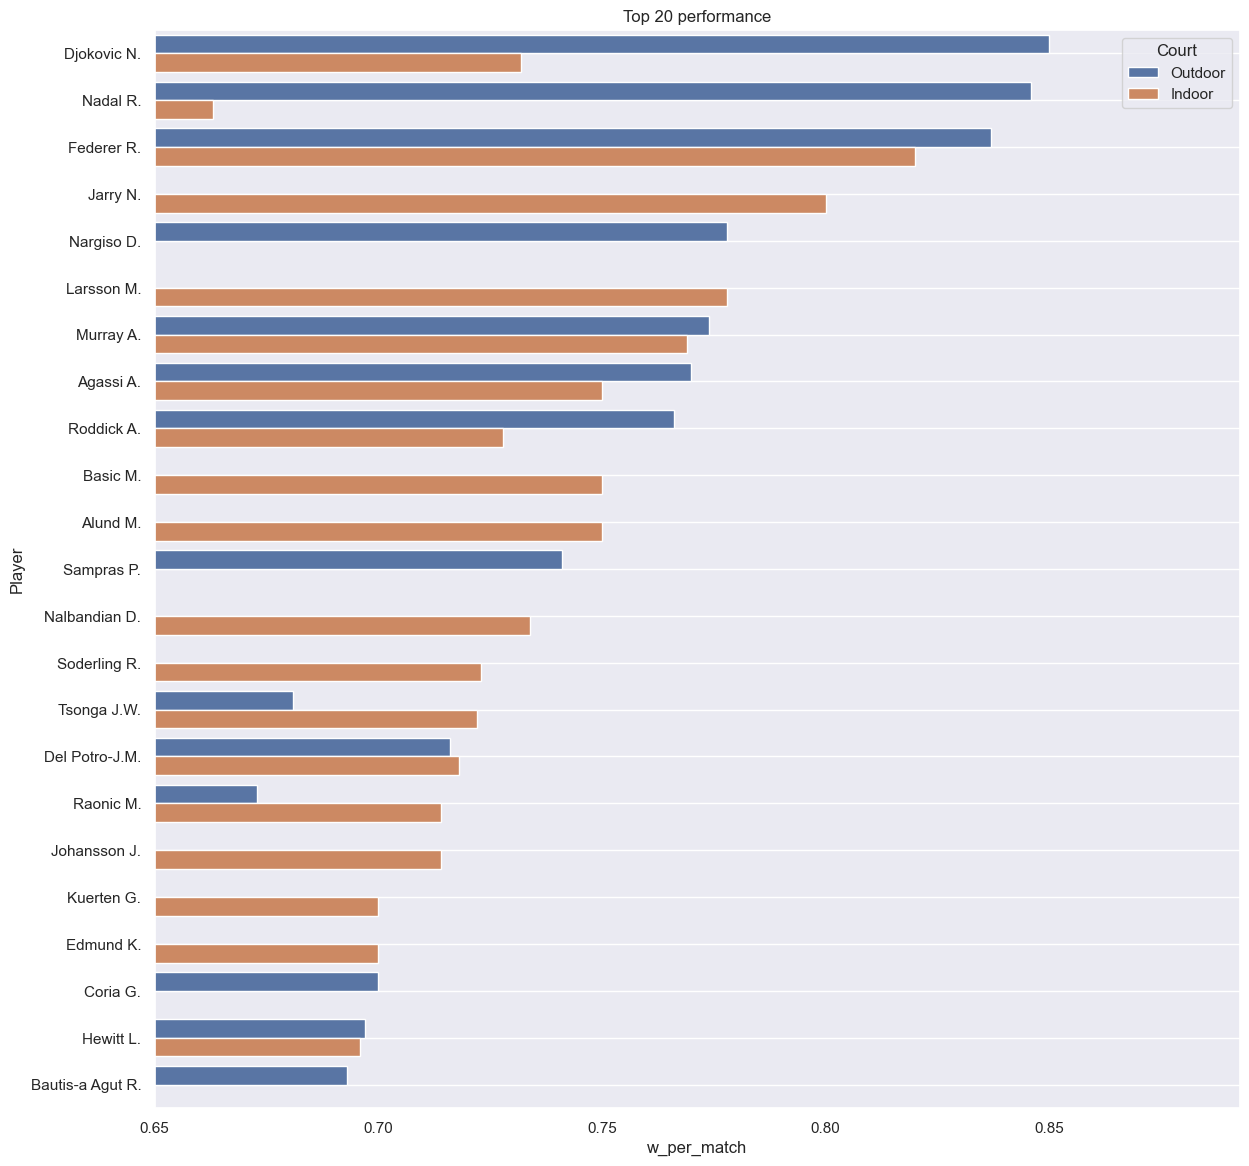

In [45]:
# Top 20 performces

plt.figure(figsize=(14,14))

y_uniq = win_loss_cou.head(30).Player.unique()

data = win_loss_cou.loc[win_loss_cou.Player.isin(y_uniq)]
x, y = data.w_per_match, data.Player
sns.barplot(x=x, y=y, data=data, hue='Court', orient='h'); plt.xlim((0.65, None));
plt.title('Top 20 performance'); plt.grid();

#### Is there a correlation between performance and surface type?
##### Let's proceed with a statistical test: ANOVA test

### 2.4. Performances pitch type

,Player,Surface,Winner,Loser,matches,w_per_match
392,Nadal R.,Clay,340.0,31,371.0,0.916
666,Federer R.,Grass,137.0,17,154.0,0.890
1917,Rafter P.,Grass,12.0,2,14.0,0.857
123,Djokovic N.,Hard,435.0,80,515.0,0.845
57,Federer R.,Hard,589.0,110,699.0,0.843


,df,sum_sq,mean_sq,F,PR(>F)
Surface,3.0,1.755389,0.585130,11.116294,2.976309e-07
Residual,2871.0,151.121189,0.052637,NaN,NaN


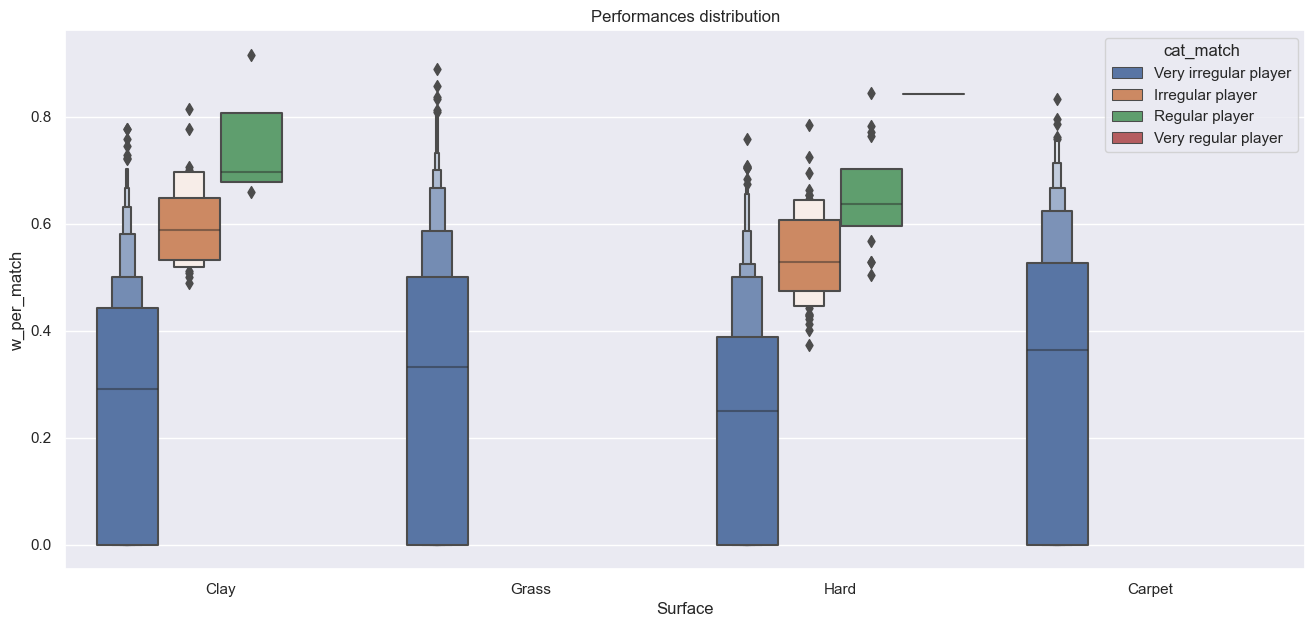

In [46]:
# buffer dataFrame

winner_tampon = pd.DataFrame(df1[['Winner', 'Surface']].value_counts()).reset_index()
winner_tampon.rename({'Winner' : 'Player', 0: 'Winner'}, inplace=True, axis=1)

loser_tampon = pd.DataFrame(df1[['Loser', 'Surface']].value_counts()).reset_index()
loser_tampon.rename({'Loser' : 'Player', 0: 'Loser'}, inplace=True, axis=1)

win_loss_sur = winner_tampon.merge(right=loser_tampon, on=['Player','Surface'], how='right')

# NAs

win_loss_sur = win_loss_sur.fillna(0)

win_loss_sur['matches'] = win_loss_sur.Winner + win_loss_sur.Loser
win_loss_sur['w_per_match'] = round(win_loss_sur.Winner / win_loss_sur.matches,3)

win_loss_sur.sort_values(by = ['w_per_match', 'Player', 'Surface'], ascending=False, inplace=True)
display(win_loss_sur.head())

# H0 : Performance and tournament type are independent

import statsmodels.api

result = statsmodels.formula.api.ols('w_per_match ~ Surface', data=win_loss_sur).fit()
table = statsmodels.api.stats.anova_lm(result)

display(table)

# The p-value (PR(>F)) is < 5%, so we reject the null hypothesis

win_loss_sur['cat_match'] = pd.cut(x=win_loss_sur.matches, bins=4, labels=labels)

# Graphical verification

plt.figure(figsize=(16,7))
sns.boxenplot(x=win_loss_sur.Surface, y=win_loss_sur.w_per_match, hue=win_loss_sur['cat_match'])
plt.title('Performances distribution');

# The graph confirms the statistical test

##### Best players performance

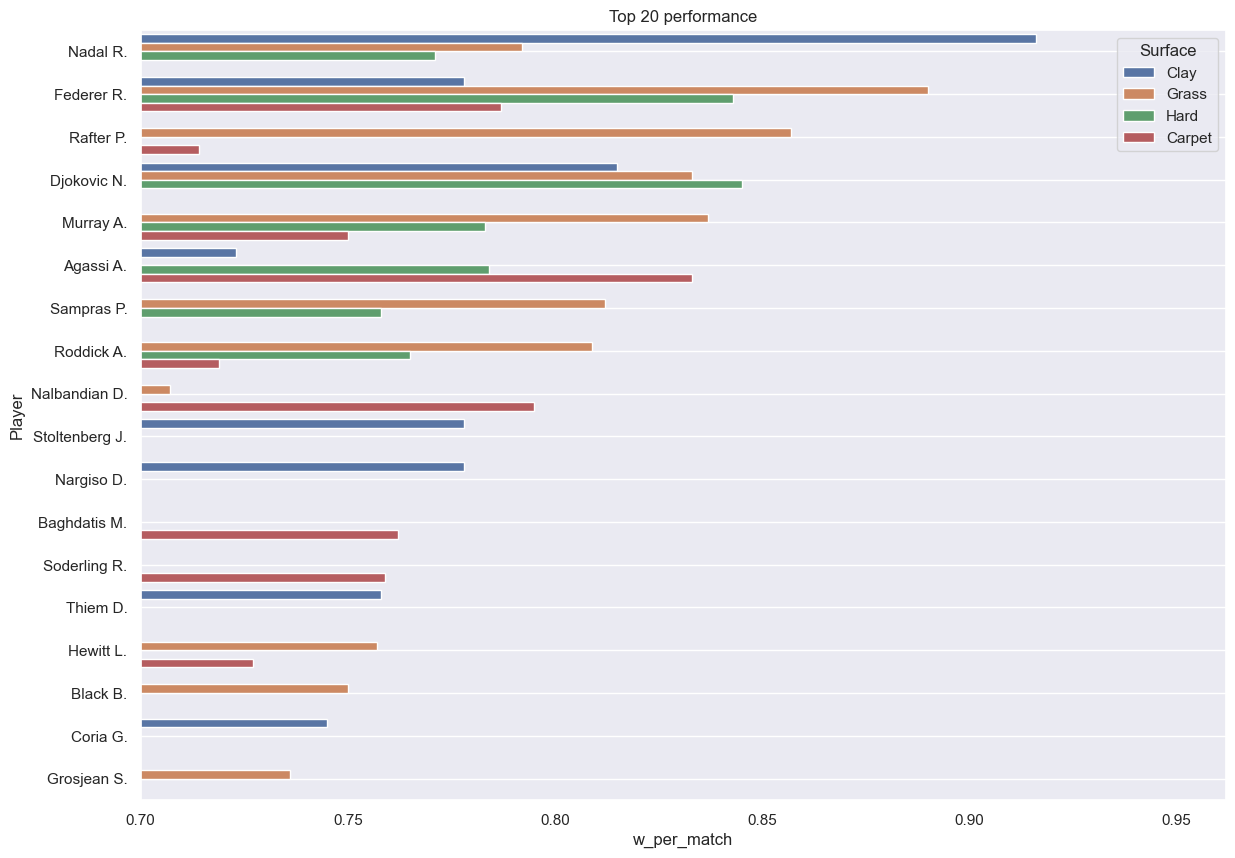

In [47]:
# Top 20 performces

plt.figure(figsize=(14,10))

y_uniq = win_loss_sur.head(30).Player.unique()

data = win_loss_sur.loc[win_loss_sur.Player.isin(y_uniq)]
x, y = data.w_per_match, data.Player
sns.barplot(x=x, y=y, data=data, hue='Surface', orient='h'); plt.xlim((0.7, None));
plt.title('Top 20 performance'); plt.grid();

##### Apart from Federer who seems to be the most versatile player, we see that the surface has a strong influence on performance.
##### Nadal is the most glaring example. He wins almost 93% of his matches on clay, but only wins 77% of matches on 'Hard'. That is about 16 delta points.

### 2.5. Is the ranking hierarchy always respected?

#### Proportion of matches won by Outsider

In [48]:
outsider_tampon = pd.DataFrame(df1.loc[df1.WRank > df1.LRank, ['Series', 'Court', 'Surface']].value_counts(), 
                               columns=['outsider_win'])
challenger_tampon = pd.DataFrame(df1.loc[-(df1.WRank > df1.LRank), ['Series', 'Court', 'Surface']].value_counts(), 
                                 columns=['challenger_win'])
cha_out = challenger_tampon.join(outsider_tampon)
cha_out.head()

,,,challenger_win,outsider_win
Series,Court,Surface,,
Grand Slam,Outdoor,Hard,2918,1074
International,Outdoor,Clay,2472,1355
ATP250,Outdoor,Clay,1996,1149
Masters 1000,Outdoor,Hard,1808,900
International,Outdoor,Hard,1778,935


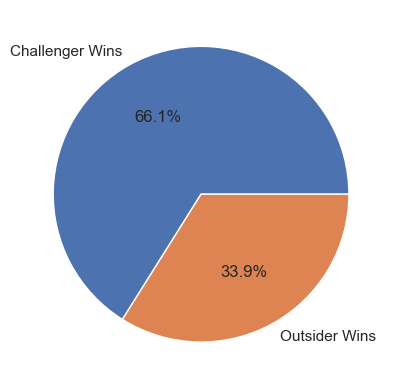

In [49]:
#plt.figure(figsize=(9,6))
sizes=[cha_out.challenger_win.sum(), cha_out.outsider_win.sum()]
plt.pie(sizes,labels=['Challenger Wins', 'Outsider Wins'], autopct="%.1f%%")#, normalize=True)
plt.show()

##### We observe that Challengers win approximately twice more than Outsiders

### 2.6 Bookmakers performance

In [50]:
df1.iloc[:,7:].head()

,Round,Best of,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,1st Round,3,Dosedel S.,Ljubicic I.,63,77,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
1,1st Round,3,Kiefer N.,Tarango J.,6,59,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
2,1st Round,3,Gaudio G.,Luxa P.,73,174,2,1,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
3,1st Round,3,El Aynaou- Y.,Dupuis A.,33,78,2,1,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
4,1st Round,3,Cherkasov A.,Arazi H.,206,35,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5


In [51]:
# 3 possibilities : win for challenger, loss for challenger or draw

In [52]:
atp_challenger_win, atp_outsider_win, atp_draw = len(df1[df1.WRank < df1.LRank]), len(df1[df1.WRank > df1.LRank]), len(df1[df1.WRank == df1.LRank])

ps_challenger_win, ps_outsider_win, ps_draw = len(df1[df1.PSW < df1.PSL]), len(df1[df1.PSW > df1.PSL]), len(df1[(df1.PSW == df1.PSL) & (df1.PSW != 1)])

b365_challenger_win, b365_outsider_win, b365_draw = len(df1[df1.B365W < df1.B365L]), len(df1[df1.B365W > df1.B365L]), len(df1[(df1.B365W == df1.B365L) & (df1.B365W != 1)])

elo_challenger_win, elo_outsider_win, elo_draw = len(df1[df1.proba_elo > 0.5]), len(df1[df1.proba_elo < 0.5]), len(df1[df1.proba_elo == 0.5])

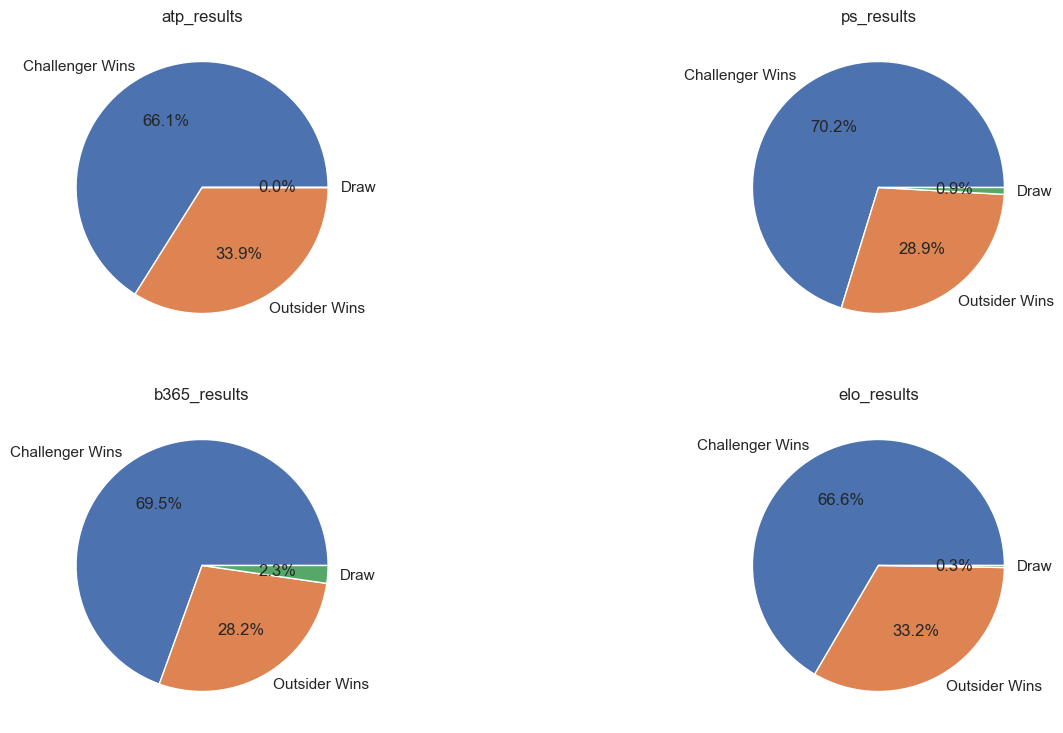

In [53]:
atp_results = [atp_challenger_win, atp_outsider_win, atp_draw]
ps_results = [ps_challenger_win, ps_outsider_win, ps_draw]
b365_results = [b365_challenger_win, b365_outsider_win, b365_draw]
elo_results = [elo_challenger_win, elo_outsider_win, elo_draw]

pie_charts = [atp_results, ps_results, b365_results, elo_results]
fig = plt.figure(figsize=(16,9))

ax1 = fig.add_subplot(221)
ax1.pie(pie_charts[0], labels=['Challenger Wins', 'Outsider Wins', 'Draw'], autopct="%.1f%%")#, normalize=True)
ax1.set_title('atp_results')

ax2 = fig.add_subplot(222)
ax2.pie(pie_charts[1], labels=['Challenger Wins', 'Outsider Wins', 'Draw'], autopct="%.1f%%")#, normalize=True)
ax2.set_title('ps_results')

ax3 = fig.add_subplot(223)
ax3.pie(pie_charts[2], labels=['Challenger Wins', 'Outsider Wins', 'Draw'], autopct="%.1f%%")#, normalize=True)
ax3.set_title('b365_results')

ax4 = fig.add_subplot(224)
ax4.pie(pie_charts[3], labels=['Challenger Wins', 'Outsider Wins', 'Draw'], autopct="%.1f%%")#, normalize=True)
ax4.set_title('elo_results')
plt.show();

In [54]:
# Bookmakers (B365 and PS) are right 70% of time. 

#### Do bookmakers always have the outsider and challenger ? 

In [55]:
len(df1[(df1.PSW < df1.PSL) & (df1.B365W > df1.B365L)]) / len(df1) * 100

0.4579904217231599

##### Yes they do.

# 3. Predictions - Model

### 3.1 Data preprocessing / Features engineering

In [56]:
# Lets change the dataset structure

In [57]:
display(df1.iloc[:,:10].head())
df1.iloc[:,10:25].head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,El Aynaou- Y.
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.


,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,Ljubicic I.,63,77,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
1,Tarango J.,6,59,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
2,Luxa P.,73,174,2,1,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
3,Dupuis A.,33,78,2,1,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
4,Arazi H.,206,35,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5


In [58]:
df2 = df1.copy()

df2['player1'] = df2.Winner.copy()
df2['player2'] = df2.Loser.copy()
df2.drop('Loser', axis=1, inplace=True)
df2.rename({'Winner': 'player1_wins', 'WRank': 'rank1', 'LRank': 'rank2', 'Wsets': 'sets1', 'Lsets': 'sets2',
            'PSW': 'ps1', 'PSL': 'ps2', 'B365W': 'b365_1', 'B365L': 'b365_2', 'elo_winner': 'elo1', 
            'elo_loser': 'elo2', 'Date':'date'}, axis=1, inplace=True)

df3 = df2.copy()

df2.loc[:,'player1_wins'], df3.loc[:,'player1_wins'] = -1, 1

df2.player1, df2.player2 = df3.player2, df3.player1
df2.rank1, df2.rank2 = df3.rank2, df3.rank1
df2.sets1, df2.sets2 = df3.sets2, df3.sets1
df2.ps1, df2.ps2 = df3.ps2, df3.ps1
df2.b365_1, df2.b365_2 = df3.b365_2, df3.b365_1
df2.elo1, df2.elo2 = df3.elo2, df3.elo1

df2 = df2.append(df3, ignore_index=True)
del df3

display(df2.iloc[:,:10].head())
df2.iloc[:,10:].head()

C:\Users\fadil\AppData\Local\Temp\ipykernel_93924\1361140109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(df3, ignore_index=True)


,ATP,Location,Tournament,date,Series,Court,Surface,Round,Best of,player1_wins
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,-1
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,-1
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,-1
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,-1
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,-1


,rank1,rank2,sets1,sets2,Comment,ps1,ps2,b365_1,b365_2,elo1,elo2,proba_elo,player1,player2
0,77,63,0,2,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5,Ljubicic I.,Dosedel S.
1,59,6,0,2,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5,Tarango J.,Kiefer N.
2,174,73,1,2,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5,Luxa P.,Gaudio G.
3,78,33,1,2,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5,Dupuis A.,El Aynaou- Y.
4,35,206,0,2,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5,Arazi H.,Cherkasov A.


In [59]:
df

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.500000
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.500000
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.500000
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,El Aynaou- Y.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.500000
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44703,17,Dubai,Dubai Tennis Championships,2018-03-03,ATP500,Outdoor,Hard,The Final,3,Bautis-a Agut R.,...,2.0,0.0,Completed,1.65,2.43,1.66,2.20,1835.901543,1842.459807,0.490563
44704,16,Acapulco,Abierto Mexicano,2018-03-03,ATP500,Outdoor,Hard,Semifinals,3,Anderson K.,...,2.0,1.0,Completed,1.34,3.63,1.30,3.50,1843.576914,1647.967561,0.755103
44705,18,Sao Paulo,Brasil Open,2018-03-03,ATP250,Indoor,Clay,Semifinals,3,Jarry N.,...,2.0,1.0,Completed,1.85,2.09,1.90,1.90,1588.293069,1619.758421,0.454841
44706,16,Acapulco,Abierto Mexicano,2018-03-04,ATP500,Outdoor,Hard,The Final,3,Del Potro-J.M.,...,2.0,0.0,Completed,1.52,2.75,1.50,2.62,1966.532849,1851.413609,0.659862


In [62]:
col_to_keep = ['Tournament', 'Round', 'player1_wins', 'rank1', 'rank2', 'ps1', 'ps2', 'b365_1', 'b365_2',
               'elo1', 'elo2', 'player1', 'player2'] #+ col_prev_match
df_final = df2[col_to_keep]

In [63]:
df_final.iloc[30:40,:]

,Tournament,Round,player1_wins,rank1,rank2,ps1,ps2,b365_1,b365_2,elo1,elo2,player1,player2
30,Qatar Open,2nd Round,-1,39,47,1.0,1.0,1.0,1.0,1500.0,1518.808638,Vacek D.,Schuettler R.
31,Gold Flake Open,2nd Round,-1,111,162,1.0,1.0,1.0,1.0,1500.0,1484.736307,Stanoytchev O.,Delgado J.
32,Qatar Open,2nd Round,-1,49,44,1.0,1.0,1.0,1.0,1500.0,1499.295977,Squillari F.,Schalken S.
33,Qatar Open,2nd Round,-1,71,74,1.0,1.0,1.0,1.0,1516.0,1499.363541,Marin J.A.,Mirnyi M.
34,Qatar Open,2nd Round,-1,211,6,1.0,1.0,1.0,1.0,1516.0,1517.406490,Caratti C.,Kiefer N.
35,Qatar Open,2nd Round,-1,73,33,1.0,1.0,1.0,1.0,1516.0,1514.630251,Gaudio G.,El Aynaou- Y.
36,Qatar Open,2nd Round,-1,60,85,1.0,1.0,1.0,1.0,1516.0,1501.403778,Berasategui A.,Bastl G.
37,Qatar Open,1st Round,-1,50,39,1.0,1.0,1.0,1.0,1500.0,1484.865325,Vicente F.,Vacek D.
38,Qatar Open,1st Round,-1,62,83,1.0,1.0,1.0,1.0,1500.0,1501.406397,Ivanisevic G.,Tillstrom M.
39,Qatar Open,1st Round,-1,93,49,1.0,1.0,1.0,1.0,1500.0,1483.967579,Siemerink J.,Squillari F.


In [64]:
#df2.loc[df2.player1 == 'Luxa P.'].sort_values(by='date', ascending=False).iloc[:,[3,9,10,25,26,34,35]]

In [65]:
data = df_final.drop(['player1_wins'], axis=1)
target = df_final.player1_wins

In [66]:
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=.7)

In [67]:
X_train_num, X_test_num = X_train.select_dtypes(include=np.number), X_test.select_dtypes(include=np.number)
X_train_cat1, X_test_cat1 = X_train[['Round']], X_test[['Round']]
X_train_cat2, X_test_cat2 = X_train[['Tournament', 'player1', 'player2']], X_test[['Tournament', 'player1', 'player2']]

In [68]:
# We standardize numerical values :
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), index=X_train.index, columns = X_train_num.columns)
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), index=X_test.index, columns = X_test_num.columns)

In [80]:
# We encode our categorical values :
oneh = OneHotEncoder(handle_unknown = 'ignore')

X_train_cat_encod1 = pd.DataFrame(oneh.fit_transform(X_train_cat1).toarray(), index=X_train.index, columns = oneh.get_feature_names_out())
X_test_cat_encod1 = pd.DataFrame(oneh.transform(X_test_cat1).toarray(), index=X_test.index, columns = oneh.get_feature_names_out())

In [70]:
# We encode our categorical values :
le1 = LabelEncoder()
le2 = LabelEncoder()

le2.fit(data.loc[:,'player1'].append(data.loc[:,'player2'], ignore_index=True).drop_duplicates())

X_train_cat_encod2 = pd.DataFrame({X_train_cat2.columns[0] : le1.fit_transform(X_train_cat2.iloc[:,0]),
                                   X_train_cat2.columns[1] : le2.transform(X_train_cat2.iloc[:,1]),
                                   X_train_cat2.columns[2] : le2.transform(X_train_cat2.iloc[:,2])}, index=X_train.index)
X_test_cat_encod2 = pd.DataFrame({X_test_cat2.columns[0] : le1.fit_transform(X_test_cat2.iloc[:,0]),
                                   X_test_cat2.columns[1] : le2.transform(X_test_cat2.iloc[:,1]),
                                   X_test_cat2.columns[2] : le2.transform(X_test_cat2.iloc[:,2])}, index=X_test.index)

C:\Users\fadil\AppData\Local\Temp\ipykernel_93924\1380154253.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  le2.fit(data.loc[:,'player1'].append(data.loc[:,'player2'], ignore_index=True).drop_duplicates())


In [71]:
X_train = pd.concat([X_train_cat_encod1, X_train_cat_encod2, X_train_num_scaled], axis=1)
X_test = pd.concat([X_test_cat_encod1, X_test_cat_encod2, X_test_num_scaled], axis=1)

In [72]:
#!conda install -c conda-forge py-xgboost
#!pip install --user xgboost

### 3.2 Model selection

In [76]:
# Model definition
lr = LogisticRegression()
knn = KNeighborsClassifier(2)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
#ac = AdaBoostClassifier()

#xg = xgboost.XGBClassifier()
#xg.fit(X_train, y_train.replace({-1:0}))
#xg.score(X_test, y_test.replace({-1:0}))

# Model training
lr.fit(X_train, y_train)
print("score du lr : {}".format(lr.score(X_test, y_test)))

dt.fit(X_train, y_train)
print("score du dt : {}".format(dt.score(X_test, y_test)))

#ac.fit(X_train, y_train)
#print("score du ac : {}".format(ac.score(X_test, y_test)))

knn.fit(X_train, y_train)
print("score du knn : {}".format(knn.score(X_test, y_test)))

rf.fit(X_train, y_train)
print("score du rf : {}".format(rf.score(X_test, y_test)))

#xg.fit(X_train, y_train.replace({-1:0}))
#print("score du xg : {}".format(xg.score(X_test, y_test.replace({-1:0}))) )

score du lr : 0.6961137587663219
score du dt : 0.6066100972528963


C:\Users\fadil\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


score du knn : 0.5310163121391762
score du rf : 0.6875121081793173


In [77]:
# Model prediction
y_pred_lr = lr.predict(X_test) 

# Classification report
print(classification_report(y_test, y_pred_lr))

# Correlation matrix
pd.crosstab(y_test, y_pred_lr, rownames=['Real class'], colnames=['lr prediction class'])

              precision    recall  f1-score   support

          -1       0.70      0.69      0.69     12982
           1       0.69      0.71      0.70     12827

    accuracy                           0.70     25809
   macro avg       0.70      0.70      0.70     25809
weighted avg       0.70      0.70      0.70     25809



lr prediction class,-1,1
Real class,,
-1,8922,4060
1,3783,9044


In [78]:
# Our models struggle to overperform the bookmakers predictions.
# As reminder, bookmakers hs a score close to 70%.
# We must improve our model

### 3.3 Hyperparameters tunning : Nested Cross-Validation

In [79]:
# Model definition
lr = LogisticRegression()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
xg = xgboost.XGBClassifier()
ac = AdaBoostClassifier(dt)

NameError: name 'xgboost' is not defined

In [ ]:
param_grid_lr = {'C': np.linspace(0.05, 1, 20), 
              'penalty' : ['l1', 'l2'], 
              'solver' : ['lbfgs', 'liblinear']}

param_grid_knn = {'n_neighbors' : np.arange(2,3), 'metric' : ['manhattan', 'minkowski']}

param_grid_rf = {'n_jobs': [-1, 1, 10], 'criterion':["gini", "entropy"]}

param_grid_ac = {'base_estimator__max_depth' : [i for i in range(2,9,2)],
              #'base_estimator__min_samples_leaf':[5,10],
              #'n_estimators':[10,250,1000],
              'learning_rate':[0.01,0.1]}

param_grid_xg = {"learning_rate"    : [0.05, 0.03, 0.01] , "booster": ['gbtree', 'dart'],
 "max_depth"        : [7,9,10],
 "gamma"            : [0.4, 0.3, 0.2],
 "colsample_bytree" : [0.4, 0.3, 0.2] }

In [ ]:
gridcvs = dict()
gridcvs['lr'] = GridSearchCV(lr, param_grid_lr, scoring='accuracy', cv=3, refit=True)
gridcvs['knn'] = GridSearchCV(knn, param_grid_knn, scoring='accuracy', cv=3, refit=True)
gridcvs['rf'] = GridSearchCV(rf, param_grid_rf, scoring='accuracy', cv=3, refit=True)
gridcvs['ac'] = GridSearchCV(ac, param_grid_ac, scoring='accuracy', cv=3, refit=True)
gridcvs['xg'] = GridSearchCV(xg, param_grid_xg, scoring='accuracy', cv=3, refit=True).fit(X_train, y_train.replace({-1:0}))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

gridcvs['lr'].fit(X_train, y_train)
resultats_cv = pd.DataFrame(gridcvs['lr'].cv_results_)[['params', 'mean_test_score', 'std_test_score']]
display(resultats_cv.loc[resultats_cv.params == gridcvs['lr'].best_params_])
resultats_cv

In [ ]:
# No improvement

In [ ]:
#dump(dt, 'C:\\Users\\00080609\\OneDrive - ENERCON\\GitHub\\PyBet\\PyBet---Bet\\Streamlit\\Models\\dt_pybet.joblib')
#dump(knn, 'C:\\Users\\00080609\\OneDrive - ENERCON\\GitHub\\PyBet\\PyBet---Bet\\Streamlit\\Models\\knn_pybet.joblib')
#dump(rf, 'C:\\Users\\00080609\\OneDrive - ENERCON\\GitHub\\PyBet\\PyBet---Bet\\Streamlit\\Models\\rf_pybet.joblib')
dump(lr, 'C:\\Users\\00080609\\OneDrive - ENERCON\\GitHub\\PyBet\\PyBet---Bet\\Streamlit\\Models\\lr_pybet.joblib')

In [ ]:
'''loaded_model = load('M:\\53-01-Reportings_KPI\\lr_pybet.joblib')

loaded_model.predict(X_train)'''

# 4. Is it possible to win money ?

### Our model is not doing better than the bookmakers predictions. We can then follow their strategy and check if we can win.
As the goal is to beat the bookmakers, we should find the best way to bet without loosing money. It imply not only to accurately forecast the winner, but also to choose the right game bet on.

###### Lets imagine we bet € 10 on Nadal with an odd of  1,5. Possible outcomes are :
    - Nadal wins : I win € 15
    - Nadal loose : I win € 0
In the first case, our ROI (Return On Investment) is 50%.
In the first case, our ROI (Return On Investment) is -100%.

That is to say :
    
    ROI = (odd * bet - bet) / bet = odd - 1    if prediction right
    ROI =                         = - 100 %    if prediction wrong

To beat the bookmakers, ROI should be positive.

In [ ]:
def allocation_paris(base_cagnotte=0, mise_min=100, mise_max=1000, sureté=0.8):
    y_pred_proba = lr.predict_proba(X_test) 
    
    cagnotte = base_cagnotte
    
    mise_totale = 0
    
    y_pred_proba2 = [probas for probas in y_pred_proba]
    
    for i, probas in zip(y_test.index, y_pred_proba2):
    #for i, probas in enumerate(y_pred_proba):    
        cotes_1 = df_final[['ps1', 'b365_1']].loc[i]
        cotes_2 = df_final[['ps2', 'b365_2']].loc[i]
        
        probas_test = probas[1]
        if probas[1]>sureté:
            if y_test.loc[i]==1:
                print('bet {}€ on player1 victory -'.format(round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))) ,
                      'match id {}'.format(i),
                      'on {}, odd to {} -'.format(cotes_1.idxmax()[:-1], cotes_1.max()),
                      'WIN!! - total : {}€'.format(cagnotte + round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_1.max()-1))))
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_1.max()-1))
            else:
                print('bet {}€ on player1 victory -'.format(round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))) ,
                      'on {}, odd to {} -'.format(cotes_2.idxmax()[:-1], cotes_2.max()),
                      'LOOSE!! - total : {}€'.format(cagnotte - round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))))
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
        
        probas_test = probas[0]
        if probas[0]>sureté:
            if y_test.loc[i]==-1:
                print('bet {}€ on player2 victory -'.format(round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))) ,
                      'on {}, odd to {} -'.format(cotes_2.idxmax()[:-1], cotes_2.max()),
                      'WIN!! - total : {}€'.format(cagnotte + round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_2.max()-1))))
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_2.max()-1))
            else:
                print('bet {}€ on player2 victory -'.format(round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))) ,
                      'on {}, odd to {} -'.format(cotes_2.idxmax()[:-1], cotes_2.max()),
                      'LOOSE!! - total : {}€'.format(cagnotte - round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))))
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
                
        
    print("La mise totale a été de ", mise_totale)
    print("La cagnote est de ", cagnotte)
    return cagnotte

In [ ]:
def allocation_paris2(base_cagnotte=0, mise_min=100, mise_max=1000, sureté=0.8):
    y_pred_proba = lr.predict_proba(X_test) 
    
    cagnotte = base_cagnotte
    
    mise_totale = 0
    
    y_pred_proba2 = [probas for probas in y_pred_proba]
    
    for i, probas in zip(y_test.index, y_pred_proba2):
    #for i, probas in enumerate(y_pred_proba):    
        cotes_1 = df_final[['ps1', 'b365_1']].loc[i]
        cotes_2 = df_final[['ps2', 'b365_2']].loc[i]
        
        probas_test = probas[1]
        if probas_test>sureté:
            if y_test.loc[i]==1:
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_1.max()-1))
            else:
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
        
        probas_test = probas[0]
        if probas_test>sureté:
            if y_test.loc[i]==-1:
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_2.max()-1))
            else:
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            
    print('La cagnotte est de : ', cagnotte) 
    print('...Pour une mise totale de : ', mise_totale)

In [ ]:
def allocation_paris3(base_cagnotte=0, mise_min=100, mise_max=1000, sureté=0.8):
    y_pred_proba = lr.predict_proba(X_test) 
    
    cagnotte = base_cagnotte
    
    mise_totale = 0
    
    y_pred_proba2 = [probas for probas in y_pred_proba]
    
    for i, probas in zip(y_test.index, y_pred_proba2):
    #for i, probas in enumerate(y_pred_proba):    
        cotes_1 = df_final[['ps1', 'b365_1']].loc[i]
        cotes_2 = df_final[['ps2', 'b365_2']].loc[i]
        
        probas_test = probas[1]
        if probas_test>sureté:
            if y_test.loc[i]==1:
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_1.max()-1))
            else:
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
        
        probas_test = probas[0]
        if probas_test>sureté:
            if y_test.loc[i]==-1:
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_2.max()-1))
            else:
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            
    return cagnotte

In [ ]:
allocation_paris()

In [ ]:
allocation_paris2()

In [ ]:
security = np.arange(0.8,1,0.03)
jackpot = []
for i in security:
    jackpot.append(allocation_paris3(sureté = i))
jackpot = np.array(jackpot)

In [ ]:
plt.plot(security, jackpot);

In [ ]:
# Conclusion
# It is not possible to beat the bookmakers

# 5. Interpretability

### 5.1 Skater : Features importance

In [ ]:
pd.Series(np.abs(lr.coef_[0]), X_train.columns).sort_values(ascending=False).plot(kind='barh', figsize=(4,8));

### 5.2 SHAP

In [ ]:
#!pip install skater

In [ ]:
#!pip install shap

In [ ]:
import shap


explainer = shap.LinearExplainer(lr, X_test)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

In [ ]:
shap.dependence_plot('ps1', shap_values, X_test, interaction_index= "Tournament")

shap.dependence_plot('b365_2', shap_values, X_test, interaction_index= "x0_The Final")

shap.dependence_plot("Tournament", shap_values, X_test, interaction_index= "x0_The Final")

In [ ]:
#Utiliser SHAP car PCA uniquement pour variable quantitatives
#Models avec et sans bookmakers